In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras

import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout


from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import tensorflow as tf

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-04-14 04:54:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.253.123.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   116MB/s    in 0.6s    

2023-04-14 04:54:30 (116 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
print(len(os.listdir('/tmp/cats_and_dogs_filtered/train/cats')))
print(len(os.listdir('/tmp/cats_and_dogs_filtered/train/dogs')))

1000
1000


In [ ]:
try:
    os.mkdir('/cats_and_dogs_filtered')
    os.mkdir('/tmp/cats_and_dogs_filtered/training')
    os.mkdir('/tmp/cats_and_dogs_filtered/validation')
    os.mkdir('/tmp/cats_and_dogs_filtered/train/cats')
    os.mkdir('/tmp/cats_and_dogs_filtered/train/dogs')
    os.mkdir('/tmp/cats_and_dogs_filtered/validation/cats')
    os.mkdir('/tmp/cats_and_dogs_filtered/validation/dogs')
except OSError:
    pass

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
l_train=[]
l_val=[]

import os

for diretorio, subpastas, arquivos in os.walk(train_dogs_dir):
    for arquivo in arquivos:
        l_train.append(os.path.join(diretorio, arquivo))

for diretorio, subpastas, arquivos in os.walk(train_cats_dir):
    for arquivo in arquivos:
        l_train.append(os.path.join(diretorio, arquivo))

for diretorio, subpastas, arquivos in os.walk(validation_dogs_dir):
    for arquivo in arquivos:
        l_val.append(os.path.join(diretorio, arquivo))

for diretorio, subpastas, arquivos in os.walk(validation_cats_dir):
    for arquivo in arquivos:
        l_val.append(os.path.join(diretorio, arquivo))

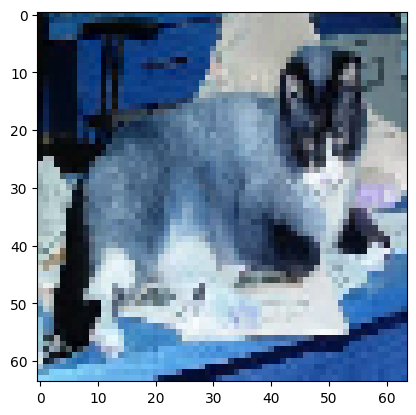

In [ ]:
input_dimensions = (64, 64)
images_train = []
images_val = []

for i in l_train:
    m = cv2.imread(i)
    m = cv2.resize(m, input_dimensions)

    #aplicação de normalização
    m = m.astype('float32') / 255
    
    images_train.append(m)

#plt.imshow(images_train[len(images_train)-1])

for i in l_val:
    m = cv2.imread(i)
    m = cv2.resize(m, input_dimensions)

    #aplicação de normalização
    m = m.astype('float32') / 255

    images_val.append(m)

plt.imshow(images_val[len(images_val)-1])

Peguei todas as imagens dos diretorios do kaggle e coloquei em listas. Apliquei também uma normalização para que o modelo generalize melhor.

In [ ]:
images_train_np = np.array(images_train)
images_val_np = np.array(images_val)

In [ ]:
# Sampling function
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
#Encoder
latent_dim = 2
img_size = 64
input_shape = (img_size, img_size, 3)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

#Decoder
decoder_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

#z = Lambda(sampling)([z_mean, z_log_var])
z = Sampling()([z_mean, z_log_var])

# Define the VAE model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 4096)              12288     
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       9248

In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               281620    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         77795     
                                                                 
Total params: 359,415
Trainable params: 359,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1) 
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

In [ ]:
batch_size = 32

vae.compile(optimizer='adam')
vae.fit(images_train_np, epochs=30, batch_size=batch_size, validation_data=(images_val_np, None))

Epoch 1/30
63/63 [==============================] - 37s 545ms/step - loss: 813.5071 - kl_loss: 0.0123 - reconstruction_loss: 813.4949 - val_loss: 811.0452 - val_kl_loss: 2.3454e-05 - val_reconstruction_loss: 811.0452
Epoch 2/30
63/63 [==============================] - 31s 500ms/step - loss: 803.8477 - kl_loss: 3.3012e-05 - reconstruction_loss: 803.8477 - val_loss: 811.7549 - val_kl_loss: 4.8637e-05 - val_reconstruction_loss: 811.7549
Epoch 3/30
63/63 [==============================] - 34s 531ms/step - loss: 804.9153 - kl_loss: 3.8473e-05 - reconstruction_loss: 804.9153 - val_loss: 810.8243 - val_kl_loss: 5.0038e-05 - val_reconstruction_loss: 810.8243
Epoch 4/30
63/63 [==============================] - 35s 554ms/step - loss: 804.2931 - kl_loss: 8.8544e-05 - reconstruction_loss: 804.2930 - val_loss: 809.6820 - val_kl_loss: 1.3131e-04 - val_reconstruction_loss: 809.6818
Epoch 5/30
63/63 [==============================] - 33s 524ms/step - loss: 802.7781 - kl_loss: 1.5161e-04 - reconstructi

32/32 [==============================] - 5s 120ms/step


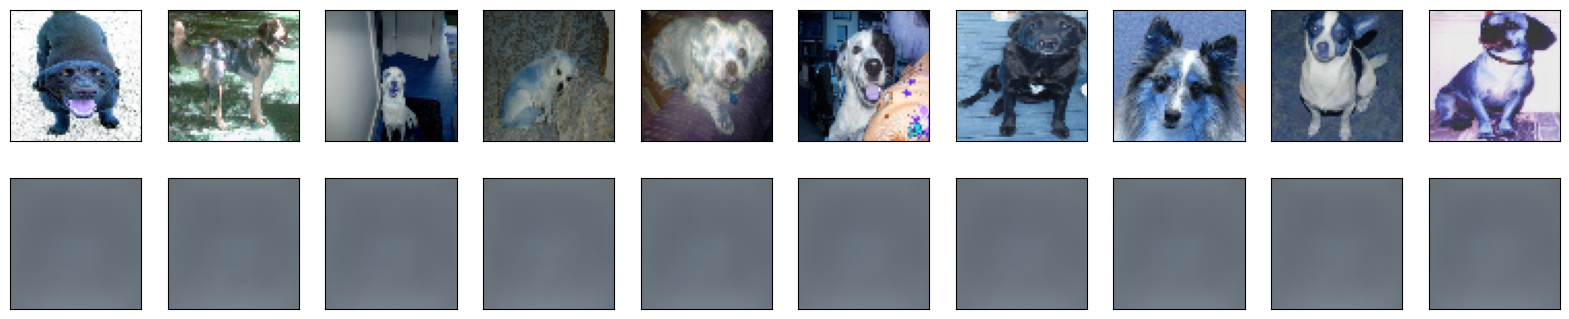

In [ ]:
# Convert the predictions into images
decoded_imgs = vae.predict(images_val_np)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_val_np[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 176ms/step


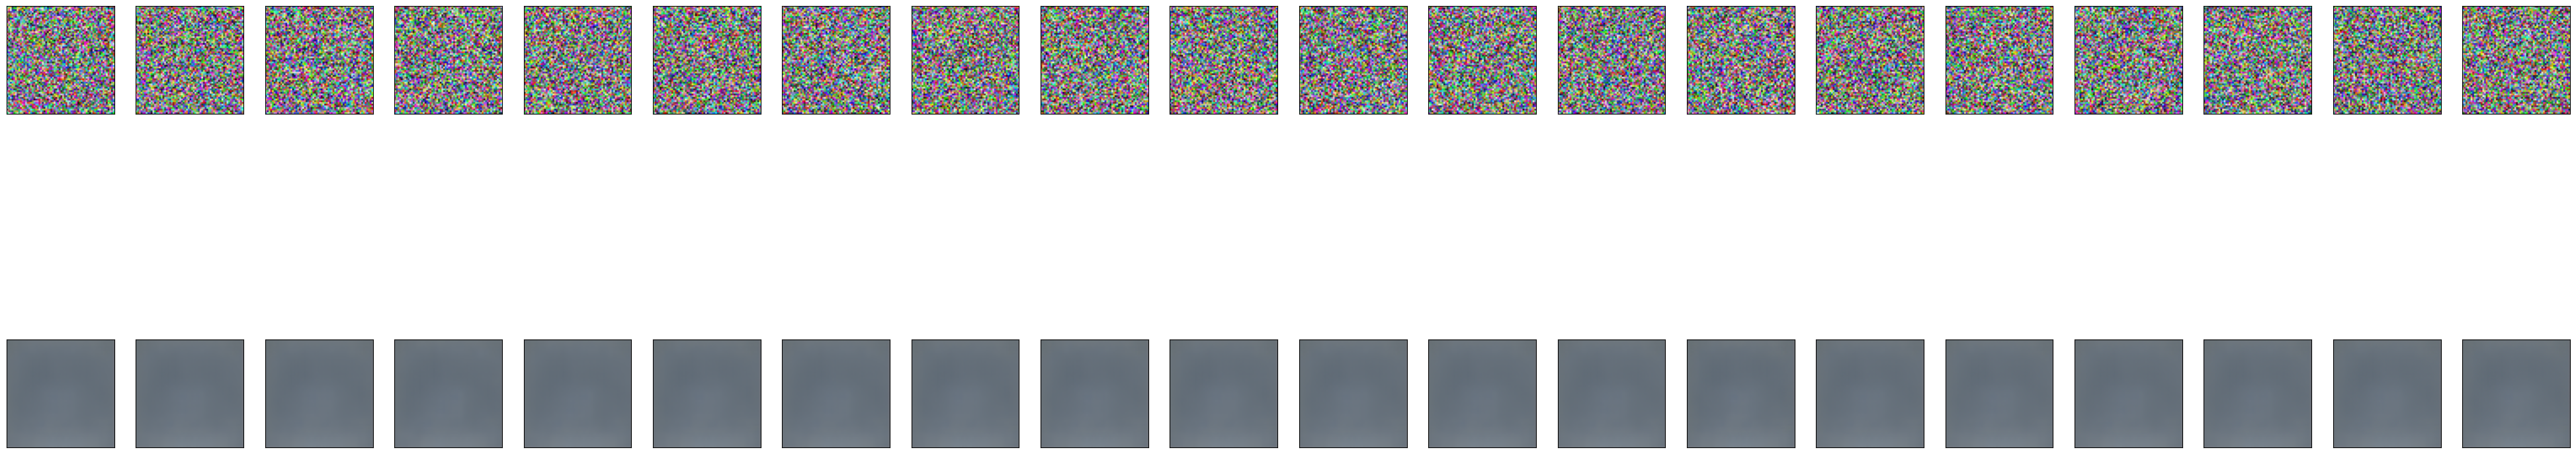

In [ ]:
# Convert the predictions into images
num_samples = 20
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = num_samples # number of images to display
plt.figure(figsize=(50, 12))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Alguns pontos importantes:

1- Usei as imagens da competição de dogs vs cats do kaggle https://www.kaggle.com/competitions/dogs-vs-cats/data

2- Rodei o modelo por 30 epocas sem grandes alterações na loss.

3- Diferente do mnist, onde a "estrutura" das imagens sao mais simples, para fazer uma reprodução melhor de imagens mais complexas acredito que precise fazer uma especie de tunning de hiperparametros, regularização, testar outras funções de otimização e etc. Mas infelizmente para o poder computacional que eu tenho atualmente fica impossível, pois só para rodar essas 30 epocas, demorou quase 20min. Tendo isso em mente, acredito que para o modelo generalizar melhor, ja que claramente está sofrendo overfitting, precisaria fazer tudo isso que eu falei acima.

4- Como consequencia do overfitting, as distribuições geradas pelo encoder também não estão boas, logo, as interpolações entre uma imagem e outra não estão com resultados satisfatorios, como podemos ver na imagem acima.

Qualquer duvida, fico a disposição.
Obrigado.